<a href="https://colab.research.google.com/github/marco10507/ml-portfolio/blob/main/stroke_prediction_draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import gdown
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

file_id = '1AbKB9-FUmOwJpAipx8ij4V60eLvPRCKr'
download_url = f'https://drive.google.com/uc?id={file_id}'
gdown.download(download_url, 'healthcare-dataset-stroke-data.csv', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1AbKB9-FUmOwJpAipx8ij4V60eLvPRCKr
To: /content/healthcare-dataset-stroke-data.csv
100%|██████████| 317k/317k [00:00<00:00, 68.9MB/s]


'healthcare-dataset-stroke-data.csv'

In [ ]:
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.pipeline import Pipeline
from sklearn.neighbors import NearestNeighbors

def run_grid_search_with_smote(X_train, y_train, smote_variant, param_grid):
    pipeline = Pipeline([
        ('smote', smote_variant),
        ('model', GradientBoostingClassifier(random_state=42))
    ])

    grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        cv=5,
        scoring='roc_auc',  # Using F1 score for imbalanced classification
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)

    return grid_search

def run_all_smote_grid_searches(X_train, y_train):
    smote_variants = {
      'SMOTE': SMOTE(random_state=42),
      'BorderlineSMOTE': BorderlineSMOTE(random_state=42),
      'ADASYN': ADASYN(random_state=42)
    }

    # Define hyperparameters for grid search
    param_grids = {
        'ADASYN': {
            "smote__n_neighbors": [3, 5, 7, 10, 15],
            'smote__sampling_strategy': ['minority', 'not majority', 0.5],
            "model__learning_rate": [0.01, 0.1, 0.2],
            "model__max_depth": [3, 5, 7],
            "model__subsample" : [0.8, 0.9, 1]
        },
        'SMOTE': {
            "smote__k_neighbors": [3, 5, 7, 10, 15],
            "model__n_estimators": [50, 100, 150],
            "model__learning_rate": [0.01, 0.1, 0.2],
            "model__max_depth": [3, 5, 7],
            "model__subsample" : [0.8, 0.9, 1]
        },
        'BorderlineSMOTE': {
            "smote__k_neighbors": [3, 5, 7, 10, 15],
            "smote__m_neighbors": [3, 5, 7, 10],
            "smote__kind": ['borderline-1', 'borderline-2'],
            "model__learning_rate": [0.01, 0.1, 0.2],
            "model__max_depth": [3, 5, 7],
            "model__subsample" : [0.8, 0.9, 1]
        }
    }

    results = {}
    for smote_name, smote_variant in smote_variants.items():
        param_grid = param_grids[smote_name]
        grid_search = run_grid_search_with_smote(X_train, y_train, smote_variant, param_grid)
        results[smote_name] = {
            'best_params': grid_search.best_params_,
            'best_score': grid_search.best_score_,
            'best_model': grid_search.best_estimator_
        }

    # Find the best SMOTE variant based on the highest score
    best_smote_variant = max(results, key=lambda k: results[k]['best_score'])
    best_result = results[best_smote_variant]

    return best_result

def get_feature_importances(model, feature_names, ascending=False):
    importances = model.feature_importances_

    feature_importances = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=ascending)

    return feature_importances

def plot_normalized_confusion_matrix(y_true, y_pred, class_names):
    """
    Plot a normalized confusion matrix.

    Parameters:
    y_true (array-like): True labels.
    y_pred (array-like): Predicted labels.
    class_names (list of str): List of class names.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

    # Plot normalized confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Normalized Confusion Matrix')
    plt.show()

def calcuale_optimal_threshold(tpr, fpr, thresholds):
  J = tpr - fpr
  optimal_idx = J.argmax()
  optimal_threshold = thresholds[optimal_idx]

  return (optimal_threshold, optimal_idx)

def plot_roc_curve(fpr, tpr, roc_auc, optimal_threshold, optimal_idx):
  # Plot ROC curve
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', marker='o', label=f'Optimal Threshold = {optimal_threshold:.6f}')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic')
  plt.legend(loc='lower right')
  plt.show()

def model_perfonance_evaluation(y_test, y_pred):
  print(classification_report(y_test, y_pred))
  plot_normalized_confusion_matrix(y_test, y_pred, ['no stroke', 'stroke'])

def get_search_grid():
  gbm = GradientBoostingClassifier(random_state=42)

  param_grid = {
    "n_estimators": [50, 100, 150],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7],
    "subsample" : [0.8, 0.9, 1]
  }

  search_grid = GridSearchCV(param_grid=param_grid, estimator=gbm, cv=5, n_jobs=-1, scoring='roc_auc', verbose=3)

  return search_grid

def get_search_grid_with_resampled():

  pipeline = Pipeline([
      ('smote', SMOTE(random_state=42)),
      ('model', GradientBoostingClassifier(random_state=42))
  ])

  param_grid = {
    "smote__k_neighbors": [3, 5, 7, 10, 15],
    "model__n_estimators": [50, 100, 150],
    "model__learning_rate": [0.01, 0.1, 0.2],
    "model__max_depth": [3, 5, 7],
    "model__subsample" : [0.8, 0.9, 1]
  }

  search_grid = GridSearchCV(param_grid=param_grid, estimator=pipeline, cv=5, n_jobs=-1, scoring='roc_auc', verbose=3)

  return search_grid


stroke_data = pd.read_csv('healthcare-dataset-stroke-data.csv');
stroke_data.info()
stroke_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [ ]:
print("gender unique values:", stroke_data['gender'].unique())
print("ever_married unique values:", stroke_data['ever_married'].unique())
print("work_type unique values:", stroke_data['work_type'].unique())
print("Residence_type unique values:", stroke_data['Residence_type'].unique())
print("smoking_status unique values:", stroke_data['smoking_status'].unique())

gender unique values: ['Male' 'Female' 'Other']
ever_married unique values: ['Yes' 'No']
work_type unique values: ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence_type unique values: ['Urban' 'Rural']
smoking_status unique values: ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


In [ ]:
print(stroke_data['stroke'].value_counts())

stroke
0    4861
1     249
Name: count, dtype: int64


In [ ]:
print(stroke_data['stroke'].value_counts())

stroke
0    4861
1     249
Name: count, dtype: int64


In [ ]:
stroke_data = pd.get_dummies(stroke_data, columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])

In [ ]:
print(stroke_data.columns)

Index(['id', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level',
       'bmi', 'stroke', 'gender_Female', 'gender_Male', 'gender_Other',
       'ever_married_No', 'ever_married_Yes', 'work_type_Govt_job',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children', 'Residence_type_Rural',
       'Residence_type_Urban', 'smoking_status_Unknown',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes'],
      dtype='object')


In [ ]:
features = stroke_data.drop(columns=['id', 'stroke'])
target = stroke_data['stroke'];


X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=42, test_size=0.2)

In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')

X_train['bmi'] = imputer.fit_transform(X_train[['bmi']])
X_test['bmi'] = imputer.transform(X_test[['bmi']])

In [ ]:
# search_grid = get_search_grid()
# search_grid.fit(X_train, y_train)

In [ ]:
# print("best params", search_grid.best_params_)
# print("best score", search_grid.best_score_)

In [ ]:
# # Predict probabilities on the test set
# y_probs = search_grid.predict_proba(X_test)[:, 1]

# fpr, tpr, thresholds = roc_curve(y_test, y_probs, pos_label=1)
# roc_auc = auc(fpr, tpr)

# optimal_threshold, optimal_idx = calcuale_optimal_threshold(tpr, fpr, thresholds)
# plot_roc_curve(fpr, tpr, roc_auc, optimal_threshold, optimal_idx)

# y_pred = (y_probs >= optimal_threshold).astype(int)

# model_perfonance_evaluation(y_test, y_pred)

it seems that model learn to only detect people without strokes. I will performaing oversampling

In [ ]:
# print('X_train: ', X_train.shape)
# print('y_train: ', y_train.shape)

# search_grid = run_all_smote_grid_searches(X_train, y_train)
# print("best params", search_grid['best_params'])
# print("best score", search_grid['best_score'])

In [ ]:
# # Predict probabilities on the test set
# y_probs = search_grid['best_model'].predict_proba(X_test)[:, 1]

# fpr, tpr, thresholds = roc_curve(y_test, y_probs, pos_label=1)
# roc_auc = auc(fpr, tpr)

# optimal_threshold, optimal_idx = calcuale_optimal_threshold(tpr, fpr, thresholds)
# plot_roc_curve(fpr, tpr, roc_auc, optimal_threshold, optimal_idx)

# y_pred = (y_probs >= optimal_threshold).astype(int)

# model_perfonance_evaluation(y_test, y_pred)

I see that we are now overfitting the model. So I will perform feature selection to try to recude overfitting. I will only select the 4 best features based on the feature importance. Those features are: age, avg_glucose_level, bmi and smoking_status

In [ ]:
selected_features = ['age', 'avg_glucose_level', 'bmi', 'smoking_status_smokes', 'smoking_status_never smoked', 'smoking_status_formerly smoked', 'smoking_status_Unknown']
X_train_selection = X_train[selected_features]
X_test_selection = X_test[selected_features]

print('X_train_selection features: ', X_train_selection.columns)
print('X_test_selection features: ', X_test_selection.columns)

X_train_selection features:  Index(['age', 'avg_glucose_level', 'bmi', 'smoking_status_smokes',
       'smoking_status_never smoked', 'smoking_status_formerly smoked',
       'smoking_status_Unknown'],
      dtype='object')
X_test_selection features:  Index(['age', 'avg_glucose_level', 'bmi', 'smoking_status_smokes',
       'smoking_status_never smoked', 'smoking_status_formerly smoked',
       'smoking_status_Unknown'],
      dtype='object')


best params {'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__subsample': 0.8, 'smote__k_neighbors': 7, 'smote__kind': 'borderline-1', 'smote__m_neighbors': 5}
best score 0.8258187251645369


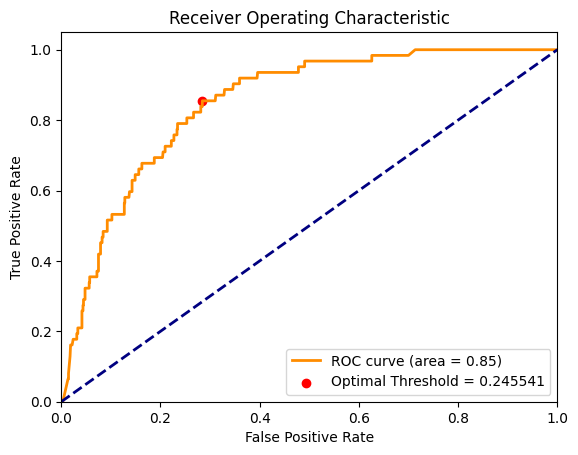

              precision    recall  f1-score   support

           0       0.99      0.72      0.83       960
           1       0.16      0.85      0.27        62

    accuracy                           0.72      1022
   macro avg       0.57      0.79      0.55      1022
weighted avg       0.94      0.72      0.80      1022



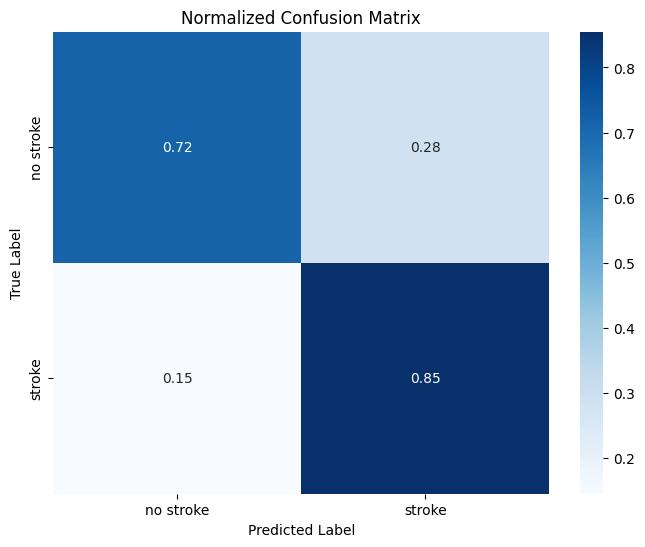

In [ ]:
search_grid = run_all_smote_grid_searches(X_train_selection, y_train)

print("best params", search_grid['best_params'])
print("best score", search_grid['best_score'])

y_probs = search_grid['best_model'].predict_proba(X_test_selection)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_probs, pos_label=1)
roc_auc = auc(fpr, tpr)

optimal_threshold, optimal_idx = calcuale_optimal_threshold(tpr, fpr, thresholds)
plot_roc_curve(fpr, tpr, roc_auc, optimal_threshold, optimal_idx)

y_pred = (y_probs >= optimal_threshold).astype(int)

model_perfonance_evaluation(y_test, y_pred)